This program figures out if a news text snippet is fake or not.

At the beginning, the program grab the news contents and labels (Fake or Not Fake) from the given dataset and extract the
features from the news contents. Then, it saves extracted data and features in a file.
With the data and features, it will decide if the news is fake or not fake using machine learning algorithms (GaussianNB
and KNeighbors Classifier are used in this program)

Features used in this program are:
1. Number of Characters
2. Number of Words
3. Number of Verbs
4. Number of Nouns
5. Number of Sentence
6. Average Number of Words per Sentence
7. Average Number of Characters in Words
8. Number of Question Marks
9. Percentage of Subjective Verbs
10. Percentage of Passive Voice
11. Percentage of Positive Words
12. Percentage of Negative Words
13. Lexical Diversity: Unique Words or Terms
14. Typographical Error Ration: Misspelled Words
15. Causation Terms

How to use: First, place positive-words.txt and negative-words.txt files in word_sentiment folder and put
            .csv dataset in liar_dataset folder in datasets folder and put the name of the .csv file
            in argument space of setup_data function. Next, use feature_extraction function with the result of
            setup_data function to extract the features and save the data in the desired file.

            * The original dataset must include the labels with true and false in second column, and news
            contents (statements) in third columns.

In [31]:
# Importing Required modules

import numpy as np
import pandas as pd
import csv

from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from collections import Counter

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [20]:
# Create the lists of the words that used for feature extraction

positive_list = list()
negative_list = list()

# Gather the positive and negative word lists from the text file
with open('./word_sentiment/positive-words.txt', encoding='ANSI') as p:
    for line in p:
        val = line.split()
        positive_list.append(val)

with open('./word_sentiment/negative-words.txt', encoding='ANSI') as n:
    for line in n:
        val = line.split()
        negative_list.append(val)

subjective_list = list(['am ', 'are ', 'is ', 'was ', 'were ', 'be ', 'been '])
causation_list = list(['led to ', 'because ', 'cause ', 'reason ', 'explanation ', 'so '])

In [21]:
# From the dataset, isolate the required data (statement and label in this program) and return as pandas Series
# If the user needs the required data as a file, uncomment def with new_file as argument and comment the other one

#def setup_data(file_name, new_file):
def setup_data(file_name):
    headernames = ['ID', 'Label', 'Statement', 'subject', 'speaker', 'sp_job', 'state info', 'party affiliation',
                   'barely true', 'false', 'half true', 'mostly ture', 'pants on fire', 'context']
    data = pd.read_csv('./datasets/liar_dataset/' + file_name, delimiter='\t', names=headernames)

    # Check for the raw data from original dataset
    # print (list(data.columns.values))
    # print(data.tail(1))

    Statement = data["Statement"]
    Label = data["Label"]
    # Check if the required data are correctly input
    # print (Statement)
    # print (Label)

    # Convert the labels to Fake or Not Fake
    Label = Label.replace("true", "Not Fake")
    Label = Label.replace("half-true", "Not Fake")
    Label = Label.replace("mostly-true", "Not Fake")
    Label = Label.replace("false", "Fake")
    Label = Label.replace("pants-fire", "Fake")
    Label = Label.replace("barely-true", "Fake")

    # Check the converted labels
    # print(Label)

    # Create a new pandas Series with statements and labels
    new = pd.concat([Statement, Label], axis=1)

    # Check if the new pandas Series correctly created
    # print(new.head(1))

    # This part is for create a file to save the new pandas Series only with Statements and Labels from the dataset
    # To use this part, uncommend this part, change the part where using this funciton with new file name as second argument and
    # add one more argument, 'new_file'

    #new_header = ['Statement', 'Labels']
    #with open(new_file, 'w') as f:
    #    writer = csv.DictWriter(f, fieldnames=new_header)
    #    writer.writeheader()
    #new.to_csv(new_file)

    return new

In [22]:
# Not required for right now, but may used in later for more efficient tockenization and feature extraction
# vectorizer = CountVectorizer()
# train_count = vectorizer.fit_transform(data["statement"].values)

# Check for vectorizer
# print(train_count.shape)
# print(vectorizer.vocabulary_)
# print(vectorizer.get_feature_names())

In [23]:
# Input: String ('str')
# Description: Tockenize and tag input with nltk universal tag
# Return: tags of each tockens - String ('tagged')
# Tockenize and tag input String with nltk universal tag and return the tags for each words in the String

def tagging_univ(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text, tagset='universal')
    return tagged

# Input: String('str')
# Description: Tockenize and tag input with nltk non-universal tag
# Return: tags of each tockens - String ('tagged')

def tagging_nuniv(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text)
    return tagged

# Input: String('str')
# Description: Count the number of characters in input
# Return: Character count - int ('count')

def count_char(str):
    no_space = str.replace(" ", "")
    count = len(no_space)
    return count

# Input: String('str')
# Description: Count the number of words in input
# Return: Word count - int ('count')

def count_word(str):
    count = len(str.split())
    return count

# Input: String ('tags'), int(verb_count)
# Description: Count the number of verbs in input
# Return: Verb count - int ('verb_count')

def count_verb(tags, verb_count):
    if (tags == 'VERB'):
        verb_count += 1
    return verb_count

# Input: String('tags'), int('noun_count')
# Description: Count the number of nouns in input
# Return: Noun count - int ('noun_count')

def count_noun(tags, noun_count):
    if (tags == 'NOUN'):
        noun_count += 1
    return noun_count

# Input: String ('str')
# Description: Count the number of sentences by counting number of period(.)
# Return: Sentence count - int ('sentence')

def count_sent(str):
    sentence = len(str.split('.'))
    return sentence

# Input: String ('states')
# Description: Count the number of characters in each word in input and average the number of characters per word
# Return: Average number of characters: float ('avg')

def count_char_per_word(states):
    word = []
    word.append(states.split())
    char_per_word = list()
    for elements in word:
        for char in elements:
            c_in_w_count = len(char)
            char_per_word.append(c_in_w_count)
    # char_per_word_list.append()
    avg = sum(char_per_word) / len(char_per_word)
    char_per_word.clear()
    return avg

# Input: String ('tagged'), list ('list'), int ('int')
# Description: Count the number of common words between input String and input list
# Return: Count of common words - int ('int')
# Count and return the number of common words between input String ('tagged') and input list

def check_common(tagged, list, int):
    for elements in list:
        if tagged in elements:
            int += 1
            return int
    return int

# Input: list ('subjective_list'), int ('verb_count'), String ('states')
# Description: Count the number of subjective words and avarage it from number of verbs in input
# Return: Average of subjective words - float ('percent_sub')

def count_sub(subjective_list, verb_count, states):
    percent_sub = 0
    for ele in subjective_list:
        sub_count = states.count(ele)
    if (verb_count > 0):
        percent_sub = sub_count / verb_count * 100
    return percent_sub

# Input: String ('word'), String ('tag'), list ('subjective_list'), int ('sent_count')
# Description: Count the number of passive voice and avarge it from number of sentence (sent_count)
# Return: Average of passive voiced sentences - float ('result')

def count_passive(word, tag, subjective_list, sent_count):
    percent_sub = 0
    counter = 0
    for ele in subjective_list:
        if (word.count(ele) > 0 and tag == "VBN"):
            counter += 1
    result = counter / sent_count * 100
    return result

# Input: String ('states')
# Description: Count the words that introduced only once in input
# Return: Count of unique words - int ('unique_count')

def count_unique(states):
    words = states.split(' ')
    c = Counter(words)
    unique = [w for w in words if c[w] == 1]
    unique_counter = len(unique)
    return unique_counter

# Input: String ('tag'), int ('typo_count')
# Description: Count the number of words with nltk universal tag is "X" (misspelled)
# Return: Count of misspelled words - int ('typo_count')

def count_typo(tag, typo_count):
    if (tag == "X"):
        typo_count += 1
    return typo_count

# Input: list ('causation_list'), String ('states')
# Description: Count the number of common words in list input and String input
# Return: Count of common words - int ('cause_count')

def count_cause(causation_list, states):
    for ele in causation_list:
        cause_count = states.count(ele)
    return cause_count

In [24]:
# Input: panda Series ('data'), String ('save_file_name')
# Description: First, this function creates lists for each features and extract the features using statements in dataset and
#              above functions. Next, it creates a large pandas Series that consist of news contents, labels and extracted
#              features. Finally, it save the final pandas Series in a file to make easier to examine the result (do not need
#              to rerun the program or change the code to check raw data)
# Return: Pandas Series consist of news contents, labels and extracted features count - pandas Series ('new')
def feature_extract(data, save_file_name):
    # define the news contents and labels from the dataset
    state = data.Statement
    label = data.Label

    # create lists for storing the counters
    char_count_list = list()
    word_count_list = list()
    verb_count_list = list()
    noun_count_list = list()
    sent_count_list = list()
    words_per_sent_list = list()
    char_per_word_list = list()
    quest_count_list = list()
    sub_count_list = list()
    pass_count_list = list()
    pos_count_list = list()
    neg_count_list = list()
    unique_count_list = list()
    typo_count_list = list()
    cause_count_list = list()
    word = list()

    # loop for checking each new contents in dataset
    for states in state:

        # reset the counters for each news contents
        w_in_s_count = 0
        c_in_w_count = 0
        verb_count = 0
        noun_count = 0
        pos_count = 0
        neg_count = 0
        percent_pos = 0
        percent_neg = 0
        unique_count = 0
        sent_counts = 0
        typo_count = 0

        # Tockenization and tagging with nltk universal and non-universal tag systems (tagged = universal, tagged_nu = non-universal)
        tagged = tagging_univ(states)
        tagged_nu = tagging_nuniv(states)

        # Check the tags of each news contents
        # print(tagged)
        # print(tagged_nu)

        # Extract the features and append the results in the list. Commented lines with print() functions are for testing

        # 1. Number of Characters
        char_count = count_char(states)
        char_count_list.append(char_count)

        # 2. Nubmer of Words
        word_count = count_word(states)
        word_count_list.append(word_count)

        # 3. Number of Verbs
        for tag in tagged:
            verb_count = count_verb(tag[1], verb_count)
        verb_count_list.append(verb_count)

        # 4. Number of Nouns
        for tag in tagged:
            noun_count = count_noun(tag[1], noun_count)
        noun_count_list.append(noun_count)
        # print(noun_count)

        # 5. Number of Sentence
        sent_count = count_sent(states)
        sent_count_list.append(sent_count)
        # print(sent_count)

        # 6. Average number of words per sentence
        sent = [len(l.split()) for l in re.split(r'[?!.]', states) if l.strip()]
        w_in_s_count = (sum(sent) / len(sent))
        words_per_sent_list.append(w_in_s_count)
        # print(w_in_s_count)

        # 7. Average number of characters per word
        c_in_w_count = count_char_per_word(states)
        char_per_word_list.append(c_in_w_count)
        # print(c_in_w_count)

        # 8. Number of question marks
        quest_count = states.count("?")
        quest_count_list.append(quest_count)

        # 9. Percentage of subjective verbs - am/are/is/etc
        percent_sub = count_sub(subjective_list, verb_count, states)
        sub_count_list.append(percent_sub)

        # 10. Percentage of passive voice - am/are/is && past participate
        for tag in tagged_nu:
            passive_percent = count_passive(tag[0], tag[1], subjective_list, sent_count)
        pass_count_list.append(passive_percent)

        # 11. Percentage of positive words
        for tag in tagged:
            pos_count = check_common(tag[0], positive_list, pos_count)
            percent_pos = pos_count / word_count * 100
        pos_count_list.append(percent_pos)

        # 12. Percentage of negative words
        for tag in tagged:
            neg_count = check_common(tag[0], negative_list, neg_count)
            percent_neg = neg_count / word_count * 100
        neg_count_list.append(percent_neg)

        # 13. Lexical diversity: unique words or terms
        unique_count = count_unique(states)
        unique_count_list.append(unique_count)

        # 14. Typographical error ratio: misspelled words
        for tag in tagged:
            typo_count = count_typo(tag[1], typo_count)
        typo_count_list.append(typo_count)

        # 15. Causation terms
        cause_count = count_cause(causation_list, states)
        cause_count_list.append(cause_count)

    # Convert lists into pandas Series

    first = pd.Series(char_count_list)
    second = pd.Series(word_count_list)
    third = pd.Series(verb_count_list)
    fourth = pd.Series(noun_count_list)
    fifth = pd.Series(sent_count_list)
    sixth = pd.Series(words_per_sent_list)
    seventh = pd.Series(char_per_word_list)
    eighth = pd.Series(quest_count_list)
    nineth = pd.Series(sub_count_list)
    tenth = pd.Series(pass_count_list)
    eleventh = pd.Series(pos_count_list)
    twelveth = pd.Series(neg_count_list)
    thirteenth = pd.Series(unique_count_list)
    fourteenth = pd.Series(typo_count_list)
    fifteenth = pd.Series(cause_count_list)

    # Concatenate all feature Series, news contents and labels into one pandas Series
    new = pd.concat([state, label, first, second, third, fourth, fifth, sixth, seventh, eighth, nineth, tenth,
                     eleventh, twelveth, thirteenth, fourteenth, fifteenth], axis=1)

    # Test for the final Series
    # print(new.head(3))

    # Name the header of the data
    new_header = ['Statement', 'Labels', '# of Characters', '# of Words', '# of Verbs', '# of Noun', '# of Sentence',
                  'Average # of Words per Sentence', 'Average # of Characters per Words', '# of Question Marks',
                  '% of Subjective Verbs', '% of Passive Voice', '% of Positive Words', '% of Negative Words',
                  '# of Unique Wrods/Terms', '# of Misspelled Words', '# of Causation Terms']

    # Save the data in a file

    with open(save_file_name, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=new_header)
        writer.writeheader()

    new.to_csv(save_file_name, header=new_header)
    # print(new)
    return new

In [25]:
# Data Extraction
# From the dataset file, gather the news contents and labels only
# *If the file only for news contents and labels, uncomment the first three lines and comment the last three lines

#train_data = setup_data('train.tsv', 'train.csv')
#test_data = setup_data('test.tsv', 'test.csv')
#valid_data = setup_data('valid.tsv', 'valid.csv')
train_data = setup_data('train.tsv')
test_data = setup_data('test.tsv')
valid_data = setup_data('valid.tsv')

# Check for shape and contents of isolated data
# print(train_data.shape)
# print(test_data.shape)
# print (valid_data.shape)
# print (train_data.head(5))
# print (test_data.head(5))
# print (valid_data.head(5))

# Feature Extraction

train_data_final = feature_extract(train_data, 'train_data.csv')
test_data_final = feature_extract(test_data, 'test_data.csv')
valid_data_final = feature_extract(valid_data, 'valid_data.csv')


# print(valid_data_final)

In [26]:
# Preprocessing

# Label Encoding
LE = preprocessing.LabelEncoder()
# Fake = 0, Not Fake = 1
train_data_final['Label'] = LE.fit_transform(train_data_final['Label'])
test_data_final['Label'] = LE.fit_transform(test_data_final['Label'])
valid_data_final['Label'] = LE.fit_transform(valid_data_final['Label'])

In [27]:
# Model Design & Evaluating

# Distinguish input (news content and features) and target (label) data for each dataset
cols = [col for col in train_data_final.columns if col not in ['Unnamed: 0', 'Label', 'Statement']]
X_train = train_data_final[cols]
Y_train = train_data_final['Label']
X_test = test_data_final[cols]
Y_test = test_data_final['Label']
X_valid = valid_data_final[cols]
Y_valid = valid_data_final['Label']

# Check for distinguished data
#print(X_test.head(n=5))
#print(Y_train.head(n=5))

GNB Accuracy:  0.4648776637726914
GNB F1 Score:  0.31376518218623484


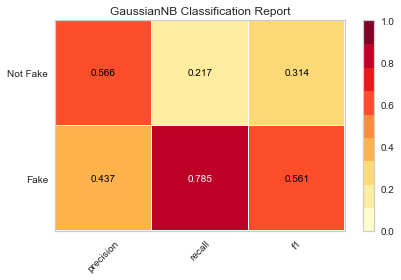

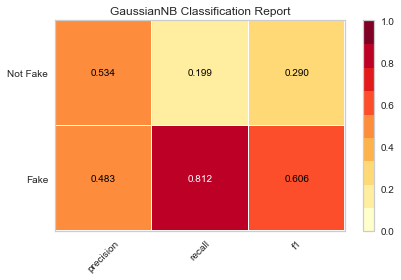

In [28]:
# GaussianNB

# Create a pipeline with StandardScaler and GaussianNB
pipeline = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))

# Fit the GaussianNB model with training set and use for predict the test set
pred = pipeline.fit(X_train, Y_train).predict(X_test)

# Print out the GaussianNB result (accuracy and f1 score)
print("GNB Accuracy: ", accuracy_score(Y_test, pred))
print("GNB F1 Score: ", f1_score(Y_test, pred))

# Output the result (percision, recall and f1 score) with test dataset as diagram
visualizer1 = ClassificationReport(pipeline, classes=['Fake', 'Not Fake'])
visualizer1.fit(X_train, Y_train)
visualizer1.score(X_test, Y_test)
visualizer1.show()

# Output the result (percision, recall and f1 score) with validation dataset as diagram
visualizer1_valid = ClassificationReport(pipeline, classes=['Fake', 'Not Fake'])
visualizer1_valid.fit(X_train, Y_train)
visualizer1_valid.score(X_valid, Y_valid)
visualizer1_valid.show()

KNeighbors Accuracy:  0.5430149960536701
KNeighbors F1 Score:  0.6063902107409924


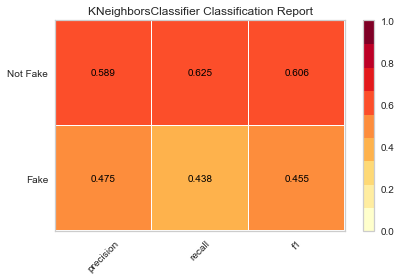

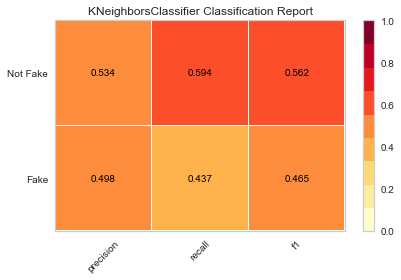

In [29]:
# KNeighbors Classifier

# Set the classifier with number of neighbors = 3
neigh = KNeighborsClassifier(n_neighbors=3)
# Fit the model with training set and predict the test set
pred1 = neigh.fit(X_train, Y_train).predict(X_test)

# Print out the KNeighborsClassifier result (accuracy and f1 score)
print("KNeighbors Accuracy: ", accuracy_score(Y_test, pred1))
print("KNeighbors F1 Score: ", f1_score(Y_test, pred1))

# Output the result (percision, recall and f1 score) with test dataset as diagram
visualizer3 = ClassificationReport(neigh, classes=['Fake', 'Not Fake'])
visualizer3.fit(X_train, Y_train)
visualizer3.score(X_test, Y_test)
visualizer3.show()

# Output the result (percision, recall and f1 score) with validation dataset as diagram
visualizer3_valid = ClassificationReport(neigh, classes=['Fake', 'Not Fake'])
visualizer3_valid.fit(X_train, Y_train)
visualizer3_valid.score(X_valid, Y_valid)
visualizer3_valid.show()

In [30]:
# Create confusion matrix with result from GaussianNB
conf_matrix1 = confusion_matrix(Y_test, pred)
print(conf_matrix1)

# Create confusion matrix with result from KNeighbors Classifier
conf_matrix2 = confusion_matrix(Y_test, pred1)
print(conf_matrix2)


[[434 119]
 [559 155]]
[[242 311]
 [268 446]]
